In [3]:
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement=True)

#最多占gpu资源的70%
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

#开始不会给tensorflow全部gpu资源 而是按需增加
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)


# 資料路徑
DATASET_PATH  = 'E:/git/3rd-ML100Days/D100/sample'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 16

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True




Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Class #0 = cats
Class #1 = dogs


d:\Anaconda3\envs\tensorflow-gpu-3.7\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [4]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Epoch 1/20
125/125 [==============================] - 64s 516ms/step - loss: 1.1233 - acc: 0.6610 - val_loss: 0.2855 - val_acc: 0.9012
Epoch 2/20
125/125 [==============================] - 50s 401ms/step - loss: 0.5275 - acc: 0.8340 - val_loss: 0.1706 - val_acc: 0.9413
Epoch 3/20
125/125 [==============================] - 50s 401ms/step - loss: 0.3476 - acc: 0.8780 - val_loss: 0.1298 - val_acc: 0.9637
Epoch 4/20
125/125 [==============================] - 51s 411ms/step - loss: 0.2855 - acc: 0.9115 - val_loss: 0.1162 - val_acc: 0.9663
Epoch 5/20
125/125 [==============================] - 52s 412ms/step - loss: 0.2344 - acc: 0.9270 - val_loss: 0.1121 - val_acc: 0.9712
Epoch 6/20
125/125 [==============================] - 52s 413ms/step - loss: 0.2321 - acc: 0.9300 - val_loss: 0.0905 - val_acc: 0.9750
Epoch 7/20
125/125 [==============================] - 52s 412ms/step - loss: 0.2105 - acc: 0.9425 - val_loss: 0.0923 - val_acc: 0.9738
Epoch 8/20
125/125 [==============================] - 5

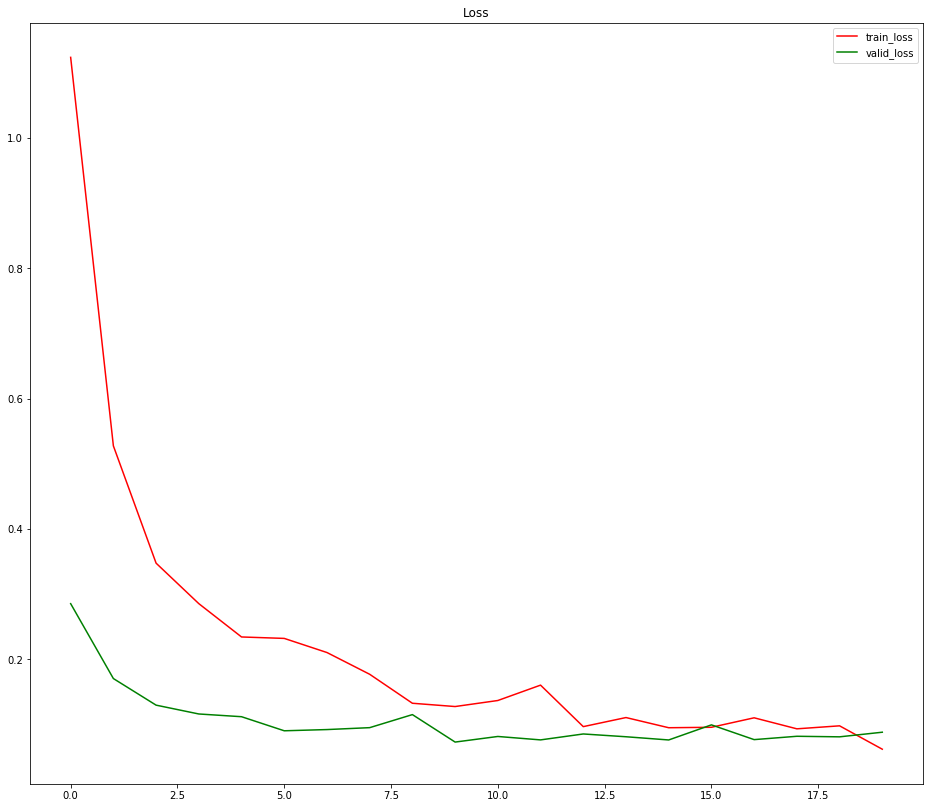

In [6]:
# Collect results
train_loss = net_final.history.history["loss"]
valid_loss = net_final.history.history["val_loss"]
train_acc = net_final.history.history["acc"]
valid_acc = net_final.history.history["val_acc"]
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
plt.plot(range(len(train_loss)),train_loss, '-', label='train_loss', color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, '-', label='valid_loss', color=color_bar[1])
plt.title("Loss")
plt.legend()
plt.show()

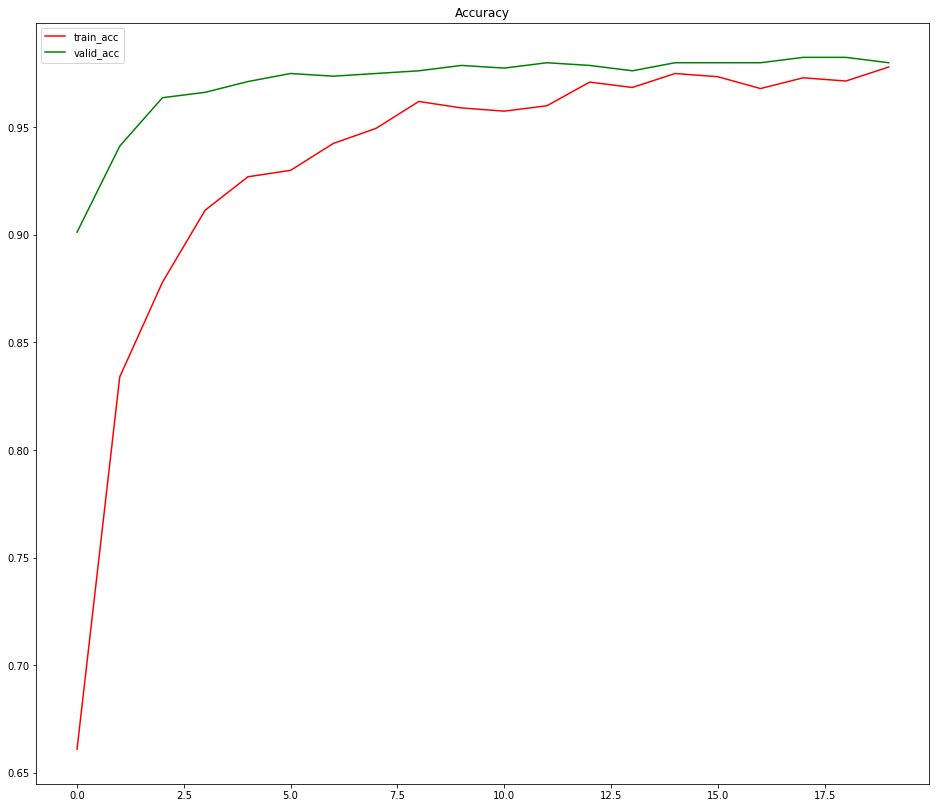

In [7]:
plt.figure(figsize=(16,14))
plt.plot(range(len(train_acc)),train_acc, '-', label='train_acc', color=color_bar[0])
plt.plot(range(len(valid_acc)),valid_acc, '-', label='valid_acc', color=color_bar[1])
plt.title("Accuracy")
plt.legend()
plt.show()